## not_mnist
- 数据集[notMNIST_large.tar.gz(235.88MB)](http://yaroslavvb.com/upload/notMNIST/notMNIST_large.tar.gz)，[notMNIST_small.tar.gz(8.07MB)](http://yaroslavvb.com/upload/notMNIST/notMNIST_small.tar.gz)
- 参考博客[ahangchen](https://github.com/ahangchen/GDLnotes/blob/master/note/lesson-1/practical.md)
- 与mnist类似，但不够干净，更接近于真实情况，比mbist任务更难
- 从`A`到`J`，共10个classes，28 * 28 image

## 下载数据集
- `download_progress_hook`显示下载进度条
- 使用`urllib.urlretrieve`获取远程数据集
- 载入文件时可以设置`force`参数，选择是否强制下载
- 返回文件路径而不是文件内容

In [1]:
from __future__ import print_function

import os
import sys

from urllib import urlretrieve
# 官方教程url需要科学上网
# url = 'https://commondatastorage.googleapis.com/books1000/'
url = 'http://yaroslavvb.com/upload/notMNIST/'
last_percent_reported = None
data_root = os.getcwd() + '/data' # Change me to store data elsewhere

def download_progress_hook(count, blockSize, totalSize):
    """
    下载进度条
    A hook to report the progress of a download. This is mostly intended for users with 
    slow internet connections. Reports every 5% change in download progress.
    """
    global last_percent_reported
    percent = int(count * blockSize * 100 / totalSize)

    if last_percent_reported != percent:
        if percent % 5 == 0:
            sys.stdout.write("%s%%" % percent)
            sys.stdout.flush()
        else:
            sys.stdout.write(".")
            sys.stdout.flush()
      
        last_percent_reported = percent
        
def maybe_download(filename, expected_bytes, force=False):
    """
    Download a file if not present, and make sure it's the right size.
    返回文件路径
    """
    dest_filename = os.path.join(data_root, filename)
    if force or not os.path.exists(dest_filename):
        print('Attempting to download:', filename)
        filename, _ = urlretrieve(url + filename, dest_filename, reporthook=download_progress_hook)
        print('\nDownload Complete!')
    statinfo = os.stat(dest_filename)
    if statinfo.st_size == expected_bytes:
        print('Found and verified', dest_filename)
    else:
        raise Exception('Failed to verify ' + dest_filename + '. Can you get to it with a browser?')
    return dest_filename

train_filename = maybe_download('notMNIST_large.tar.gz', 247336696)
test_filename = maybe_download('notMNIST_small.tar.gz', 8458043)

Found and verified /software/home/chenzh/software/jupyter/nnNote/GoogleDL/data/notMNIST_large.tar.gz
Found and verified /software/home/chenzh/software/jupyter/nnNote/GoogleDL/data/notMNIST_small.tar.gz


## 解压
- 使用tarfile
- `os.path.splittext`分离文件名与拓展名
- 返回`data_folders`列表，列表内容为`A`到`J`文件夹路径

In [3]:
import numpy as np
import tarfile

num_classes = 10
np.random.seed(133)

def maybe_extract(filename, force=False):
    root = os.path.splitext(os.path.splitext(filename)[0])[0]  # remove .tar.gz
    if os.path.isdir(root) and not force:
    # You may override by setting force=True.
        print('%s already present - Skipping extraction of %s.' % (root, filename))
    else:
        print('Extracting data for %s. This may take a while. Please wait.' % root)
        tar = tarfile.open(filename)
        sys.stdout.flush()
        tar.extractall(data_root)
        tar.close()
    data_folders = [
        os.path.join(root, d) for d in sorted(os.listdir(root)) 
        if os.path.isdir(os.path.join(root, d))] 
    if len(data_folders) != num_classes:
        raise Exception('Expected %d folders, one per class. Found %d instead.' % (num_classes, len(data_folders)))
    print(data_folders)
    return data_folders
  
train_folders = maybe_extract(train_filename)
test_folders = maybe_extract(test_filename)

/software/home/chenzh/software/jupyter/nnNote/GoogleDL/data/notMNIST_large already present - Skipping extraction of /software/home/chenzh/software/jupyter/nnNote/GoogleDL/data/notMNIST_large.tar.gz.
['/software/home/chenzh/software/jupyter/nnNote/GoogleDL/data/notMNIST_large/A', '/software/home/chenzh/software/jupyter/nnNote/GoogleDL/data/notMNIST_large/B', '/software/home/chenzh/software/jupyter/nnNote/GoogleDL/data/notMNIST_large/C', '/software/home/chenzh/software/jupyter/nnNote/GoogleDL/data/notMNIST_large/D', '/software/home/chenzh/software/jupyter/nnNote/GoogleDL/data/notMNIST_large/E', '/software/home/chenzh/software/jupyter/nnNote/GoogleDL/data/notMNIST_large/F', '/software/home/chenzh/software/jupyter/nnNote/GoogleDL/data/notMNIST_large/G', '/software/home/chenzh/software/jupyter/nnNote/GoogleDL/data/notMNIST_large/H', '/software/home/chenzh/software/jupyter/nnNote/GoogleDL/data/notMNIST_large/I', '/software/home/chenzh/software/jupyter/nnNote/GoogleDL/data/notMNIST_large/J']


## 序列化处理图像
- 考虑到内存问题，`load_letter`读取单个字母数据
- 使用`scipy.ndimage`读图
- 用ndimage读取一部分图片，用pickle将读取到的对象（ndarray对象的list）序列化存储到磁盘
- `maybe_pickle`将每个存放字母的文件夹序列化为pickle文件，并存储到本地磁盘，返回路径

In [9]:
import numpy as np
from scipy import ndimage
from six.moves import cPickle as pickle

image_size = 28  # Pixel width and height.
pixel_depth = 255.0  # Number of levels per pixel.

def load_letter(folder, min_num_images):
    """
    针对单个字母的文件夹，遍历所有图片并序列化
    返回dataset为三维数组
    Load the data for a single letter label."""
    image_files = os.listdir(folder)  # 文件列表
    dataset = np.ndarray(shape=(len(image_files), image_size, image_size), dtype=np.float32)
    print(folder)
    num_images = 0
    for image in image_files:  # 每一张图
        image_file = os.path.join(folder, image)
        try:
            image_data = (ndimage.imread(image_file).astype(float) - pixel_depth / 2) / pixel_depth  # 读图
            if image_data.shape != (image_size, image_size):
                raise Exception('Unexpected image shape: %s' % str(image_data.shape))
            dataset[num_images, :, :] = image_data
            num_images = num_images + 1
        except IOError as e:
            print('Could not read:', image_file, ':', e, '- it\'s ok, skipping.')
    
    dataset = dataset[0:num_images, :, :]
    if num_images < min_num_images:
        raise Exception('Many fewer images than expected: %d < %d' % (num_images, min_num_images))
    print('Full dataset tensor:', dataset.shape)
    print('Mean:', np.mean(dataset))
    print('Standard deviation:', np.std(dataset))
    return dataset
        
def maybe_pickle(data_folders, min_num_images_per_class, force=False):
    dataset_names = []
    for folder in data_folders:
        set_filename = folder + '.pickle'
        dataset_names.append(set_filename)
        if os.path.exists(set_filename) and not force:
            # You may override by setting force=True.
            print('%s already present - Skipping pickling.' % set_filename)
        else:
            print('Pickling %s.' % set_filename)
            dataset = load_letter(folder, min_num_images_per_class)
            try:
                with open(set_filename, 'wb') as f:
                    pickle.dump(dataset, f, pickle.HIGHEST_PROTOCOL)
            except Exception as e:
                print('Unable to save data to', set_filename, ':', e)
    return dataset_names
                      
train_datasets = maybe_pickle(train_folders, 45000)
test_datasets = maybe_pickle(test_folders, 1800)

Pickling /software/home/chenzh/software/jupyter/nnNote/GoogleDL/data/notMNIST_large/A.pickle.
/software/home/chenzh/software/jupyter/nnNote/GoogleDL/data/notMNIST_large/A
Could not read: /software/home/chenzh/software/jupyter/nnNote/GoogleDL/data/notMNIST_large/A/Um9tYW5hIEJvbGQucGZi.png : cannot identify image file '/software/home/chenzh/software/jupyter/nnNote/GoogleDL/data/notMNIST_large/A/Um9tYW5hIEJvbGQucGZi.png' - it's ok, skipping.
Could not read: /software/home/chenzh/software/jupyter/nnNote/GoogleDL/data/notMNIST_large/A/RnJlaWdodERpc3BCb29rSXRhbGljLnR0Zg==.png : cannot identify image file '/software/home/chenzh/software/jupyter/nnNote/GoogleDL/data/notMNIST_large/A/RnJlaWdodERpc3BCb29rSXRhbGljLnR0Zg==.png' - it's ok, skipping.
Could not read: /software/home/chenzh/software/jupyter/nnNote/GoogleDL/data/notMNIST_large/A/SG90IE11c3RhcmQgQlROIFBvc3Rlci50dGY=.png : cannot identify image file '/software/home/chenzh/software/jupyter/nnNote/GoogleDL/data/notMNIST_large/A/SG90IE11c3Rh

## 显示图像

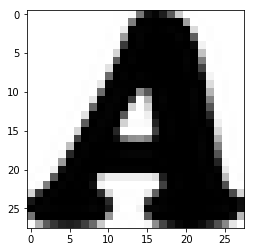

In [25]:
import matplotlib.pyplot as plt

def load_pickle(pickle_name):
    # load a pickle file to memory
    if os.path.exists(pickle_name):
        return pickle.load(open(pickle_name, "r"))
    return None

def show_imgs(imgs, show_max=-1):
    show_cnt = show_max
    if show_max == -1:
        show_cnt = len(imgs)

    for image_index in xrange(show_cnt):
        # they are binary images, if RGBs, don't add cmap="Graeys"
        plt.imshow(imgs[image_index], cmap="Greys")
        plt.show()

imgs_A = load_pickle(train_datasets[0])  # 读入A.pickle
show_imgs(imgs_A, 1)

## 训练集、测试集、验证集
- 训练集200000、测试集10000、验证集10000
- `random.shuffle`将数据乱序

In [26]:
def make_arrays(nb_rows, img_size):
    '''初始化'''
    if nb_rows:
        dataset = np.ndarray((nb_rows, img_size, img_size), dtype=np.float32)
        labels = np.ndarray(nb_rows, dtype=np.int32)
    else:
        dataset, labels = None, None
    return dataset, labels

def merge_datasets(pickle_files, train_size, valid_size=0):
    num_classes = len(pickle_files)
    valid_dataset, valid_labels = make_arrays(valid_size, image_size)
    train_dataset, train_labels = make_arrays(train_size, image_size)
    vsize_per_class = valid_size // num_classes
    tsize_per_class = train_size // num_classes
    
    start_v, start_t = 0, 0
    end_v, end_t = vsize_per_class, tsize_per_class
    end_l = vsize_per_class+tsize_per_class
    for label, pickle_file in enumerate(pickle_files):       
        try:
            with open(pickle_file, 'rb') as f:
                letter_set = pickle.load(f)
                # let's shuffle the letters to have random validation and training set
                np.random.shuffle(letter_set)
                if valid_dataset is not None:
                    valid_letter = letter_set[:vsize_per_class, :, :]
                    valid_dataset[start_v:end_v, :, :] = valid_letter
                    valid_labels[start_v:end_v] = label
                    start_v += vsize_per_class
                    end_v += vsize_per_class
                
                train_letter = letter_set[vsize_per_class:end_l, :, :]
                train_dataset[start_t:end_t, :, :] = train_letter
                train_labels[start_t:end_t] = label
                start_t += tsize_per_class
                end_t += tsize_per_class
        except Exception as e:
            print('Unable to process data from', pickle_file, ':', e)
            raise
            
    return valid_dataset, valid_labels, train_dataset, train_labels
            
            
train_size = 200000
valid_size = 10000
test_size = 10000

valid_dataset, valid_labels, train_dataset, train_labels = merge_datasets(
  train_datasets, train_size, valid_size)
_, _, test_dataset, test_labels = merge_datasets(test_datasets, test_size)

print('Training:', train_dataset.shape, train_labels.shape)
print('Validation:', valid_dataset.shape, valid_labels.shape)
print('Testing:', test_dataset.shape, test_labels.shape)

Training: (200000, 28, 28) (200000,)
Validation: (10000, 28, 28) (10000,)
Testing: (10000, 28, 28) (10000,)


## 正则化

In [27]:
def randomize(dataset, labels):
    permutation = np.random.permutation(labels.shape[0])  # 洗牌
    shuffled_dataset = dataset[permutation,:,:]
    shuffled_labels = labels[permutation]
    return shuffled_dataset, shuffled_labels
train_dataset, train_labels = randomize(train_dataset, train_labels)
test_dataset, test_labels = randomize(test_dataset, test_labels)
valid_dataset, valid_labels = randomize(valid_dataset, valid_labels)

## 保存到本地

In [28]:
pickle_file = os.path.join(data_root, 'notMNIST.pickle')

try:
    f = open(pickle_file, 'wb')
    save = {
        'train_dataset': train_dataset,
        'train_labels': train_labels,
        'valid_dataset': valid_dataset,
        'valid_labels': valid_labels,
        'test_dataset': test_dataset,
        'test_labels': test_labels,
    }
    pickle.dump(save, f, pickle.HIGHEST_PROTOCOL)
    f.close()
except Exception as e:
    print('Unable to save data to', pickle_file, ':', e)
    raise

In [29]:
statinfo = os.stat(pickle_file)
print('Compressed pickle size:', statinfo.st_size)

Compressed pickle size: 690800441


## 数据去重
- `.pickle`文件存在重复数据

In [ ]:
def clean():
    datasets = load_pickle(os.path.join(data_root , 'notMNIST.pickle'))
    test_dataset = datasets['test_dataset']
    test_labels = datasets['test_labels']
    print 